In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"   

In [2]:
def pre_process(image_file):
    image1 = cv2.imread(image_file)
    image = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image[0:10, :] = 255
    image[40:, :] = 255
    image[:, 140:] = 255
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    kernel = np.ones((3,3),np.uint8)

    new = thresh.copy()
    new[new==255] =1
    hist = np.sum(new,axis=0)
    hist[hist<7]=0
    k= np.where(hist==0)
    last2 = thresh.copy()
    last2[:,k]=0

#     sk = skeletonize(thresh == 255)*255
#     sk= np.array(sk, dtype=np.uint8)
#     sk = 255-cv2.dilate(sk,kernel, iterations=1)
    s =cv2.erode(last2,kernel, iterations=1)
    s= cv2.medianBlur(s,3)
    kernel2 = np.ones((3,1),np.uint8)
    asd = cv2.erode(thresh,kernel, iterations=1)
    
    Z= np.stack(( np.nonzero(s)[1], np.nonzero(s)[0]), axis=-1)
    Z = np.float32(Z)
    # define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(Z,5,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    
    centroids=np.sort(center[:,0])
    letters =[]
    prev = 0
    for i in range(5):
        left=int((centroids[i]+prev)/2)
    #     print('left',centroids[i],prev)

        if i==4:
            right=int(centroids[i]+13)
        else:

            right=int((centroids[i]+centroids[i+1])/2)

        x,y,w,h = left,10,abs(right-left),30
#         print(i,x,y,w,h,'|',left,right)
        letters.append((x,y,w,h))
        prev = centroids[i]
    return letters, 255-s, thresh

In [3]:
# import the necessary packages
from PIL import Image
import argparse
import pickle
import cv2
import os
import numpy as np# Hack for compatibility with different OpenCV versions
from matplotlib import pyplot as plt
import imutils
from keras.models import load_model
from helpers import resize_to_fit
from imutils import paths



MODEL_FILENAME = "captcha_model_final4.hdf5"
MODEL_LABELS_FILENAME = "model_labels5.dat"



# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
model = load_model(MODEL_FILENAME)

CAPTCHA_IMAGE_FOLDER = "images"
captcha_image_files = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))

Using TensorFlow backend.
C:\Users\zas\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


CAPTCHA text is: LAK16 predicted: LAK16 | CORRECT


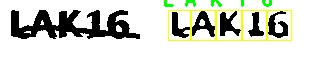

CAPTCHA text is: 0B29D predicted: 0B29D | CORRECT


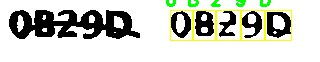

CAPTCHA text is: U8YFB predicted: U8YFB | CORRECT


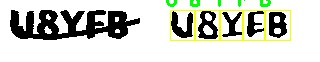

CAPTCHA text is: L4ULN predicted: L4ULN | CORRECT


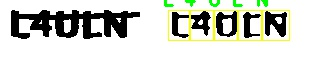

CAPTCHA text is: 86935 predicted: 86935 | CORRECT


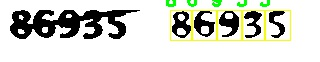

CAPTCHA text is: BRPH0 predicted: BRPH0 | CORRECT


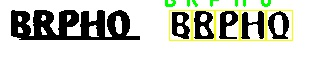

CAPTCHA text is: Z28A1 predicted: Z28A1 | CORRECT


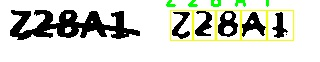

CAPTCHA text is: 6H86D predicted: 6H86D | CORRECT


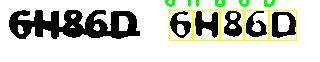

CAPTCHA text is: T1S63 predicted: T1S63 | CORRECT


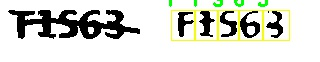

CAPTCHA text is: NUA6N predicted: NUA6N | CORRECT


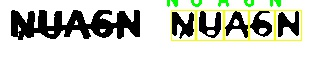

CAPTCHA text is: YB8SZ predicted: YB8SZ | CORRECT


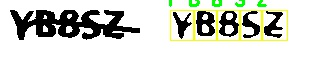

CAPTCHA text is: G8HP8 predicted: G8HP8 | CORRECT


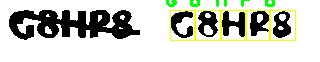

CAPTCHA text is: 5IREA predicted: 51REA | WRONG


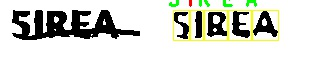

CAPTCHA text is: V4VBU predicted: V4VBU | CORRECT


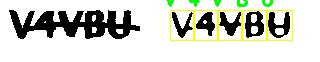

CAPTCHA text is: PY1AK predicted: PY1AK | CORRECT


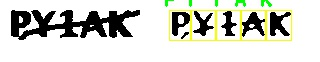

CAPTCHA text is: 19T91 predicted: 19T91 | CORRECT


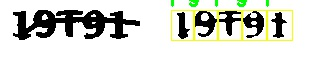

CAPTCHA text is: 8DRGN predicted: 8DRGN | CORRECT


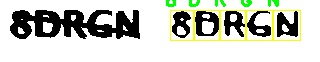

CAPTCHA text is: CT9K5 predicted: CT9K5 | CORRECT


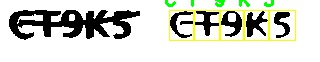

CAPTCHA text is: E47L4 predicted: E47L4 | CORRECT


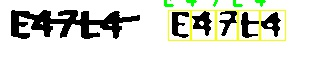

CAPTCHA text is: 9SR7G predicted: 9SR7G | CORRECT


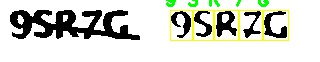

=============RESULT===============
The number of Correct Pred  :19/20
The number of Wrong Pred :1/20


In [9]:
# Grab some random CAPTCHA images to test against.
# In the real world, you'd replace this section with code to grab a real
# CAPTCHA image from a live website.
captcha_image_files = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
captcha_image_files = np.random.choice(captcha_image_files, size=(20,), replace=False)

correct = 0
wrong = 0

# loop over the image paths
for image_file in captcha_image_files:
    filename = os.path.basename(image_file).split('.')[0]
    letters, image, orig_img= pre_process(image_file)
    
    orig_img = cv2.merge([255-orig_img] * 3)
    output = cv2.merge([image] * 3)
    predictions = []
    # loop over the lektters
    for i,letter_bounding_box in enumerate(letters):
        # Grab the coordinates of the letter in the image
        if i>4:
            break
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = image[y :y+h, x+1:x + w-1]
    #         print('shape',letter_image.shape)
        # Re-size the letter image to 20x20 pixels to match training data
        letter_image = resize_to_fit(letter_image, 20, 20)

#         plt.imshow(letter_image)
#         plt.show()
        # Turn the single image into a 4d list of images to make Keras happy
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)
        
        
        
        # Ask the neural network to make a prediction
        prediction = model.predict(letter_image)
        
        # Convert the one-hot-encoded prediction back to a normal letter
        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)
 
        # draw the prediction on the output image
        
        if letter==filename[i]:
            cv2.rectangle(output, (x , y ), (x + w+1, y + h ), (0, 255, 244), 1)
            cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)
        else:
            cv2.rectangle(output, (x , y ), (x + w+1, y + h ), (0, 255, 244), 1)
            cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 0, 255), 2)
#     plt.imshow(orig_img)
#     plt.show()
    # Print the captcha's text
    captcha_text = "".join(predictions)
    if captcha_text ==filename:        
        print("CAPTCHA text is: {} predicted: {} | CORRECT".format(filename,captcha_text))
        correct += 1
    else:
        print("CAPTCHA text is: {} predicted: {} | WRONG".format(filename,captcha_text))
        wrong+=1
    # Show the annotated image
    #cv2.imshow("Output", output) #ERROR error: /tmp/build/80754af9/opencv_1512491966934/work/modules/highgui/src/window.cpp:611: error: (-2) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function cvShowImage
    #WORKAROUND https://stackoverflow.com/a/11855133/8800831
    vis = np.concatenate((orig_img, output), axis=1)
    out_img = "out/"+filename+".jpg"
    cv2.imwrite(out_img,vis)
    from IPython.display import Image
    display(Image(filename=out_img)) 
print ("=============RESULT===============")
print ("The number of Correct Pred  :{}/{}".format(correct, correct+wrong))
print ("The number of Wrong Pred :{}/{}".format(wrong, correct+wrong))